# Data Loading tutorial

To add the competition data Click File->Add or Upload data-> Search by URL -> https://www.kaggle.com/geoparslp/patreco3-multitask-affective-music

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/.DS_Store
../input/patreco3-multitask-affective-music/.DS_Store
../input/patreco3-multitask-affective-music/data/.DS_Store
../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/test_labels.txt
../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/test/11757.fused.full.npy
../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/19131.fused.full.npy
../input/patreco3-multitask-affective-music/data/multitask_dataset/train_labels.txt
../input/patreco3-multitask-affective-music/data/multitask_dataset/test/4291.fused.full.npy
../input/patreco3-multitask-affective-music/data/multitask_dataset/train/9321.fused.full.npy
../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/test_labels.txt
../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/test/11757.fused.full.npy
../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/19131.fused.full.npy
../input/patre

### Load a sample file

In [3]:
spec = np.load('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/80238.fused.full.npy')

This is a fused spectrogram + chromagram. The shape is (mel + chroma frequencies, timesteps)

In [4]:
print(spec.shape)  # (frequencies x time steps)

(140, 1293)


To decompose into the mel spectrogram and chromagram you can run:

In [5]:
mel, chroma = spec[:128], spec[128:]

In [6]:
print(mel.shape, chroma.shape)

(128, 1293) (12, 1293)


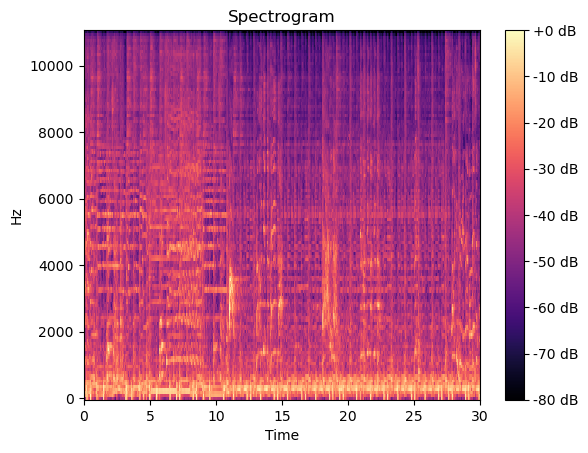

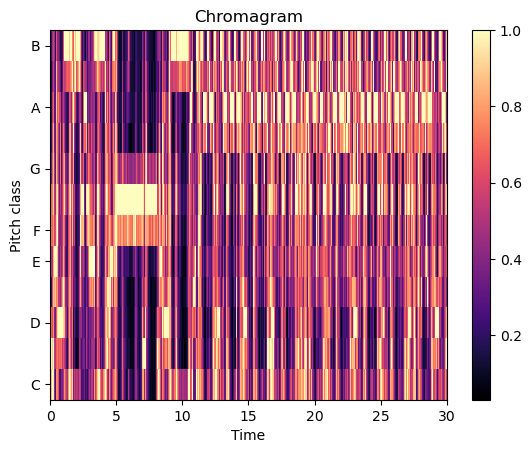

In [8]:
# Plot the spectrogram and the chromagram

import librosa.display
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
img = librosa.display.specshow(mel, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")


fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram')
fig.colorbar(img, ax=ax)

## Creating a Pytorch Dataset

We provide helper code that creates a pytorch dataset using the competition data:

In [ ]:
# Import the necessary libraries

import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}


# Helper functions to read fused, mel, and chromagram
def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T

In [ ]:
# TODO: Comment on how the train and validation splits are created.
# TODO: It's useful to set the seed when debugging but when experimenting ALWAYS set seed=None. Why?
def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


# TODO: Comment on why padding is needed
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

# Pytorch Dataset Class for creating the dataset
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)

### Create a pytorch dataset for beat synced mel spectrograms

In [ ]:
beat_mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
    
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32 ,32, val_size=.33)
     
ttest_loader_beat_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)

Lets see an example sample from the dataset

In [ ]:
datum = next(iter(train_loader_beat_mel))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch

#### Create a pytorch dataset for beat synced chromagrams


In [ ]:
beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)

train_loader_beat_chroma, val_loader_beat_chroma = torch_train_val_split(beat_chroma, 32 ,32, val_size=.33)

ttest_loader_beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)

Lets see an example sample from the beat chroma dataset

In [ ]:
datum = next(iter(train_loader_beat_chroma))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch

#### Create a pytorch dataset for the fused spectrogram + chromagram for the full (non-beat-synced) data


In [ ]:
specs_fused = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

train_loader, val_loader = torch_train_val_split(specs_fused, 32 ,32, val_size=.33)

ttest_loader = SpectrogramDataset(
     '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)

In [ ]:
datum = next(iter(train_loader))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch